In [14]:
import pandas as pd
import pickle
from data_processing import preprocess_data
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
reference = pd.read_csv('../data/raw_data.csv')
test = pd.read_csv('../data/new_data_target.csv')

In [4]:
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

In [5]:
reference_data_feats = reference.drop(columns=['diabetes'])
test_data_feats = test.drop(columns=['diabetes'])

In [6]:
processed_reference_data = preprocess_data(reference_data_feats)
processed_test_data = preprocess_data(test_data_feats)

In [9]:
reference['predicted'] = model.predict(processed_reference_data)
test['predicted'] = model.predict(processed_test_data)


In [8]:
reference.rename(columns={'diabetes': 'target'}, inplace=True)
test.rename(columns={'diabetes': 'target'}, inplace=True)

In [34]:
columns_to_convert = ["hypertension", "heart_disease", "target", "predicted"]
reference[columns_to_convert] = reference[columns_to_convert].astype('object')
test[columns_to_convert] = test[columns_to_convert].astype('object')


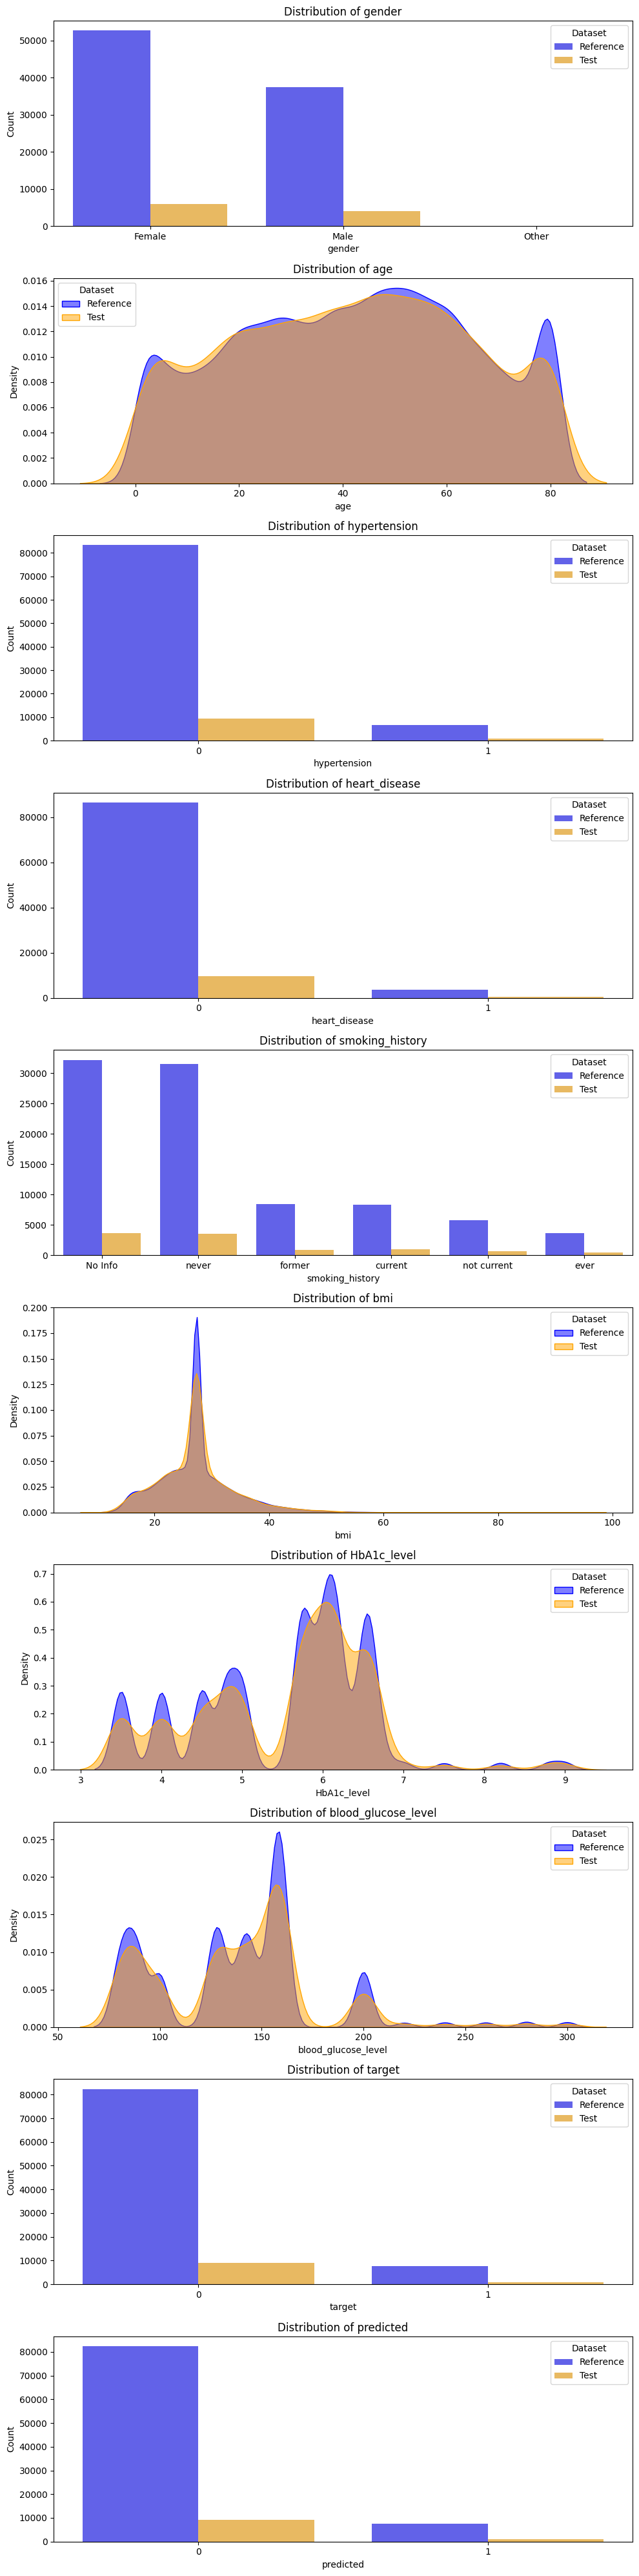

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize distributions
def visualize_distributions(reference, test):
    features = [
        "gender",
        "age",
        "hypertension",
        "heart_disease",
        "smoking_history",
        "bmi",
        "HbA1c_level",
        "blood_glucose_level",
        "target",
        "predicted"  # Add predicted if applicable
    ]

    # Set up the figure and axes
    num_features = len(features)
    fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, num_features * 4))

    for ax, feature in zip(axes, features):
        # Plot for continuous features
        if reference[feature].dtype in ['float64', 'int64']:
            sns.kdeplot(reference[feature], ax=ax, label='Reference', color='blue', fill=True, alpha=0.5)
            sns.kdeplot(test[feature], ax=ax, label='Test', color='orange', fill=True, alpha=0.5)
            ax.set_title(f'Distribution of {feature}')
            ax.set_xlabel(feature)
            ax.set_ylabel('Density')
        # Plot for binary and categorical features
        elif reference[feature].dtype == 'int64' and reference[feature].nunique() <= 2:
            # Use a combined DataFrame for plotting
            reference_counts = reference[feature].value_counts().reset_index()
            reference_counts.columns = [feature, 'count']
            reference_counts['dataset'] = 'Reference'

            test_counts = test[feature].value_counts().reset_index()
            test_counts.columns = [feature, 'count']
            test_counts['dataset'] = 'Test'

            combined_counts = pd.concat([reference_counts, test_counts])

            sns.barplot(x=feature, y='count', hue='dataset', data=combined_counts, ax=ax, palette={'Reference': 'blue', 'Test': 'orange'}, alpha=0.7)
            ax.set_title(f'Distribution of {feature}')
            ax.set_xlabel(feature)
            ax.set_ylabel('Count')
        else:
            # Use a combined DataFrame for plotting
            reference_counts = reference[feature].value_counts().reset_index()
            reference_counts.columns = [feature, 'count']
            reference_counts['dataset'] = 'Reference'

            test_counts = test[feature].value_counts().reset_index()
            test_counts.columns = [feature, 'count']
            test_counts['dataset'] = 'Test'

            combined_counts = pd.concat([reference_counts, test_counts])

            sns.barplot(x=feature, y='count', hue='dataset', data=combined_counts, ax=ax, palette={'Reference': 'blue', 'Test': 'orange'}, alpha=0.7)
            ax.set_title(f'Distribution of {feature}')
            ax.set_xlabel(feature)
            ax.set_ylabel('Count')

        ax.legend(title='Dataset')

    plt.tight_layout()
    plt.show()

# Call the function to visualize distributions
visualize_distributions(reference, test)

In [39]:
from scipy.stats import ks_2samp

def drift_analysis(reference, test, feature):
    # Calculate the KS statistic
    ks_statistic, p_value = ks_2samp(reference[feature], test[feature])

    # Drift detected if p-value < 0.05
    drift_detected = p_value < 0.05

    return {
        'KS Statistic': ks_statistic,
        'p-value': p_value,
        'Drift Detected': drift_detected
    }

# Example usage for multiple features
features = ["gender",
    "age",
    "hypertension",
    "heart_disease",
    "smoking_history",
    "bmi",
    "HbA1c_level",
    "blood_glucose_level",
    "target",
    "predicted"]
results = {feature: drift_analysis(reference, test, feature) for feature in features}

# Convert to DataFrame for better display
drift_results_df = pd.DataFrame(results).T
print(drift_results_df)

                    KS Statistic   p-value Drift Detected
gender                  0.007089  0.753549          False
age                     0.011011  0.223576          False
hypertension            0.001278       1.0          False
heart_disease           0.003133  0.999991          False
smoking_history           0.0056  0.938848          False
bmi                     0.005778  0.922945          False
HbA1c_level             0.007411  0.703185          False
blood_glucose_level     0.008656  0.507391          False
target                  0.001444       1.0          False
predicted                 0.0044  0.994665          False


In [50]:
from sklearn.metrics import f1_score
f1_score(test['target'].astype(int), test['predicted'].astype(int))

0.7390062821245003

In [51]:
f1_score(reference['target'].astype(int), reference['predicted'].astype(int))

0.9369132803781265